# [CDAF] Atividade 5

## Nome e matrícula
- **Nome:** Diogo Tuler Chaves
- **Matrícula:** 2022043663

## Referências
- [1] https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking
- [2] https://github.com/metrica-sports/sample-data

## Introdução
Nessa atividade vamos abrir, manipular e fazer algumas análises com os dados de tracking

### Imports

In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Metrica_IO as mio
import Metrica_Viz as mviz
import scipy.signal as signal

## Carregando os dados

Acesse [2] e baixe os arquivos do repositório em formato ZIP.

Depois extraia os arquivos pra uma pasta local.

Substitua o caminho da pasta com os jogos de amostra no código abaixo.

In [207]:
DATADIR = '/home/diogo/Documents/Futebol/Entrega5/sample-data-master/data'

## Parte 1

Escolha um dos jogos disponíveis na pasta. Repare que os dados estão anonimizados, então não é possível saber quem são os times e jogadores envolvidos.

In [208]:
game_id = 2 #O 3 da errado

- Utilizando os códigos disponíveis em [1] e o tutorial "Tutorial1_GettingStarted.py", carregue os dados de evento e os frames de tracking das duas equipes envolvidas no jogo escolhido.

- Em seguida, faça um plot de um evento de gol ou finalização, acrescentando a posição dos jogadores sem bola de ambas as equipes.

- Faça um plot descrevendo a trajetória do jogador que finalizou considerando os 1500 frames anteriores ao gol/finalização

### Carregamento e processamento dos dados

In [209]:
def calc_player_velocities(team, smoothing=True, filter_='Savitzky-Golay', window=7, polyorder=1, maxspeed = 12):
    """ calc_player_velocities( tracking_data )

    Calculate player velocities in x & y direciton, and total player speed at each timestamp of the tracking data

    Parameters
    -----------
        team: the tracking DataFrame for home or away team
        smoothing: boolean variable that determines whether velocity measures are smoothed. Default is True.
        filter: type of filter to use when smoothing the velocities. Default is Savitzky-Golay, which fits a polynomial of order 'polyorder' to the data within each window
        window: smoothing window size in # of frames
        polyorder: order of the polynomial for the Savitzky-Golay filter. Default is 1 - a linear fit to the velcoity, so gradient is the acceleration
        maxspeed: the maximum speed that a player can realisitically achieve (in meters/second). Speed measures that exceed maxspeed are tagged as outliers and set to NaN.

    Returrns
    -----------
       team : the tracking DataFrame with columns for speed in the x & y direction and total speed added

    """
    # remove any velocity data already in the dataframe
    team = remove_player_velocities(team)

    # Get the player ids
    player_ids = np.unique( [ c[:-2] for c in team.columns if c[:4] in ['Home','Away'] ] )

    # Calculate the timestep from one frame to the next. Should always be 0.04 within the same half
    dt = team['Time [s]'].diff()

    # index of first frame in second half
    second_half_idx = team.Period.idxmax()

    # estimate velocities for players in team
    for player in player_ids: # cycle through players individually
        # difference player positions in timestep dt to get unsmoothed estimate of velicity
        vx = team[player+"_x"].diff() / dt
        vy = team[player+"_y"].diff() / dt

        if maxspeed>0:
            # remove unsmoothed data points that exceed the maximum speed (these are most likely position errors)
            raw_speed = np.sqrt( vx**2 + vy**2 )
            vx[ raw_speed>maxspeed ] = np.nan
            vy[ raw_speed>maxspeed ] = np.nan

        if smoothing:
            if filter_=='Savitzky-Golay':
                # calculate first half velocity
                vx.loc[:second_half_idx] = signal.savgol_filter(vx.loc[:second_half_idx],window_length=window,polyorder=polyorder)
                vy.loc[:second_half_idx] = signal.savgol_filter(vy.loc[:second_half_idx],window_length=window,polyorder=polyorder)
                # calculate second half velocity
                vx.loc[second_half_idx:] = signal.savgol_filter(vx.loc[second_half_idx:],window_length=window,polyorder=polyorder)
                vy.loc[second_half_idx:] = signal.savgol_filter(vy.loc[second_half_idx:],window_length=window,polyorder=polyorder)
            elif filter_=='moving average':
                ma_window = np.ones( window ) / window
                # calculate first half velocity
                vx.loc[:second_half_idx] = np.convolve( vx.loc[:second_half_idx] , ma_window, mode='same' )
                vy.loc[:second_half_idx] = np.convolve( vy.loc[:second_half_idx] , ma_window, mode='same' )
                # calculate second half velocity
                vx.loc[second_half_idx:] = np.convolve( vx.loc[second_half_idx:] , ma_window, mode='same' )
                vy.loc[second_half_idx:] = np.convolve( vy.loc[second_half_idx:] , ma_window, mode='same' )


        # put player speed in x,y direction, and total speed back in the data frame
        team[player + "_vx"] = vx
        team[player + "_vy"] = vy
        team[player + "_speed"] = np.sqrt( vx**2 + vy**2 )

    return team

def remove_player_velocities(team):
    # remove player velocoties and acceleeration measures that are already in the 'team' dataframe
    columns = [c for c in team.columns if c.split('_')[-1] in ['vx','vy','ax','ay','speed','acceleration']] # Get the player ids
    team = team.drop(columns=columns)
    return team

In [210]:
def plot_frame( hometeam, awayteam, figax=None, team_colors=('w','b'), field_dimen = (106.0,68.0), include_player_velocities=False, PlayerMarkerSize=10, PlayerAlpha=0.7, annotate=False ):
    """ plot_frame( hometeam, awayteam )

    Plots a frame of Metrica tracking data (player positions and the ball) on a football pitch. All distances should be in meters.

    Parameters
    -----------
        hometeam: row (i.e. instant) of the home team tracking data frame
        awayteam: row of the away team tracking data frame
        fig,ax: Can be used to pass in the (fig,ax) objects of a previously generated pitch. Set to (fig,ax) to use an existing figure, or None (the default) to generate a new pitch plot,
        team_colors: Tuple containing the team colors of the home & away team. Default is 'r' (red, home team) and 'b' (blue away team)
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        include_player_velocities: Boolean variable that determines whether player velocities are also plotted (as quivers). Default is False
        PlayerMarkerSize: size of the individual player marlers. Default is 10
        PlayerAlpha: alpha (transparency) of player markers. Defaault is 0.7
        annotate: Boolean variable that determines with player jersey numbers are added to the plot (default is False)

    Returrns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)

    """
    if figax is None: # create new pitch
        fig,ax = mviz.plot_pitch( field_dimen = field_dimen )
    else: # overlay on a previously generated pitch
        fig,ax = figax # unpack tuple
    # plot home & away teams in order
    for team,color in zip( [hometeam,awayteam], team_colors) :
        x_columns = [c for c in team.keys() if c[-2:].lower()=='_x' and c!='ball_x'] # column header for player x positions
        y_columns = [c for c in team.keys() if c[-2:].lower()=='_y' and c!='ball_y'] # column header for player y positions
        ax.plot( team[x_columns], team[y_columns], color+'o', markersize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
        if include_player_velocities:
            vx_columns = ['{}_vx'.format(c[:-2]) for c in x_columns] # column header for player x positions
            vy_columns = ['{}_vy'.format(c[:-2]) for c in y_columns] # column header for player y positions
            ax.quiver( team[x_columns], team[y_columns], team[vx_columns], team[vy_columns], color=color, scale_units='inches', scale=10.,width=0.0015,headlength=5,headwidth=3,alpha=PlayerAlpha)
        if annotate:
            [ ax.text( team[x]+0.5, team[y]+0.5, x.split('_')[1], fontsize=10, color=color  ) for x,y in zip(x_columns,y_columns) if not ( np.isnan(team[x]) or np.isnan(team[y]) ) ]
    # plot ball
    ax.plot( hometeam['ball_x'], hometeam['ball_y'], 'ko', markersize=6, alpha=1.0, linewidth=0)
    return fig,ax

In [211]:
#Leitura dados de evento

eventos_jogo_2 = mio.read_event_data(DATADIR,game_id)
eventos_jogo_2 = mio.to_metric_coordinates(eventos_jogo_2)
finalizacoes_jogo_2 = eventos_jogo_2[eventos_jogo_2['Type']=='SHOT']


eventos_jogo_2_time_casa = eventos_jogo_2[eventos_jogo_2['Team']=='Home']
finalizacoes_jogo_2_time_casa = eventos_jogo_2_time_casa[eventos_jogo_2_time_casa.Type=='SHOT']



eventos_jogo_2_time_visitante = eventos_jogo_2[eventos_jogo_2['Team']=='Away']
finalizacoes_jogo_2_time_visitante = eventos_jogo_2_time_visitante[eventos_jogo_2_time_visitante.Type=='SHOT']

gols_jogo_2_time_casa = finalizacoes_jogo_2_time_casa[finalizacoes_jogo_2_time_casa['Subtype'].str.contains('-GOAL')].copy()
gols_jogo_2_time_visitante = finalizacoes_jogo_2_time_visitante[finalizacoes_jogo_2_time_visitante['Subtype'].str.contains('-GOAL')].copy()

In [212]:
gols_jogo_2_time_visitante

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
823,Away,SHOT,ON TARGET-GOAL,1,53049,2121.96,53075,2123.00,Player24,NaN,44.52,2.72,54.06,1.36
1671,Away,SHOT,ON TARGET-GOAL,2,115009,4600.36,115024,4600.96,Player20,NaN,-40.28,-1.36,-55.12,-2.72


In [213]:
gols_jogo_2_time_casa

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
198,Home,SHOT,ON TARGET-GOAL,1,12202,488.08,12212,488.48,Player10,NaN,-47.70,-3.40,-54.06,-2.04
1118,Home,SHOT,HEAD-ON TARGET-GOAL,2,73983,2959.32,73995,2959.80,Player9,NaN,47.70,-1.36,54.06,-2.04
1723,Home,SHOT,ON TARGET-GOAL,2,121027,4841.08,121055,4842.20,Player12,NaN,30.74,-5.44,54.06,-2.72


In [214]:
#Leitura dados de tracking
tracking_jogo_2_time_casa = mio.tracking_data(DATADIR,game_id,'Home')
tracking_jogo_2_time_visitante = mio.tracking_data(DATADIR,game_id,'Away')

#Converter para metros 
tracking_jogo_2_time_casa = mio.to_metric_coordinates(tracking_jogo_2_time_casa)
tracking_jogo_2_time_visitante = mio.to_metric_coordinates(tracking_jogo_2_time_visitante)

Reading team: home
Reading team: away


### Plot de um evento de gol ou finalização

In [215]:
def plotar_frame_adaptado(index):
    fig,ax = mviz.plot_pitch()
    ax.plot( eventos_jogo_2.loc[index]['Start X'], eventos_jogo_2.loc[index]['Start Y'], 'ro' )
    ax.annotate("G", xy=eventos_jogo_2.loc[index][['End X','End Y']], xytext=eventos_jogo_2.loc[index][['Start X','Start Y']], alpha=0.6, arrowprops=dict(arrowstyle="->",color='r'))
    goal_frame = eventos_jogo_2.loc[index]['Start Frame']
    fig,ax = plot_frame( tracking_jogo_2_time_casa.loc[goal_frame], tracking_jogo_2_time_visitante.loc[goal_frame], figax = (fig,ax) )
    plt.title(f'Campo no frame {index}')

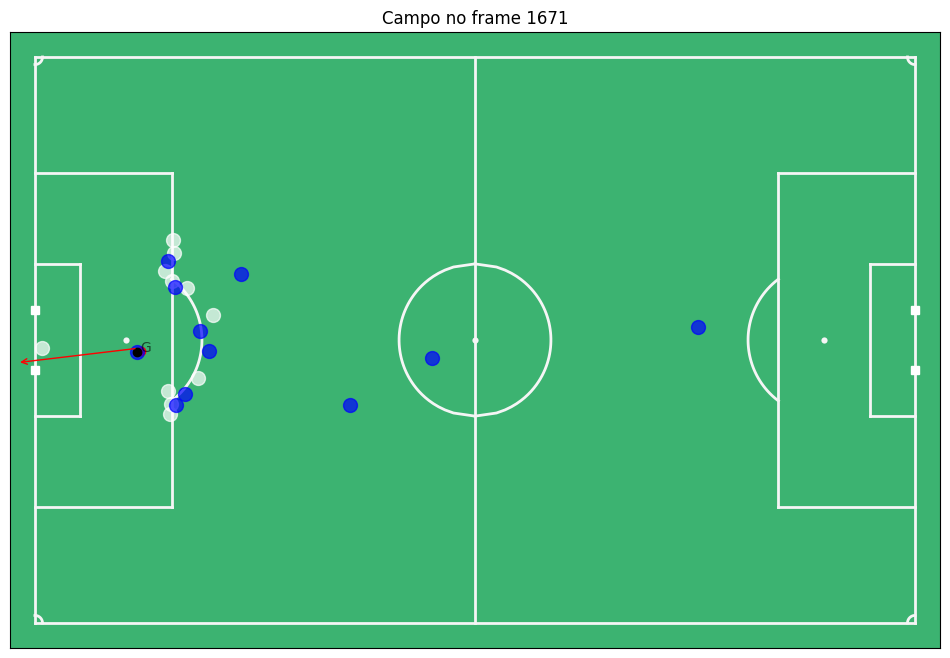

In [216]:
plotar_frame_adaptado(1671)

Penâlti, vamos escolher outro

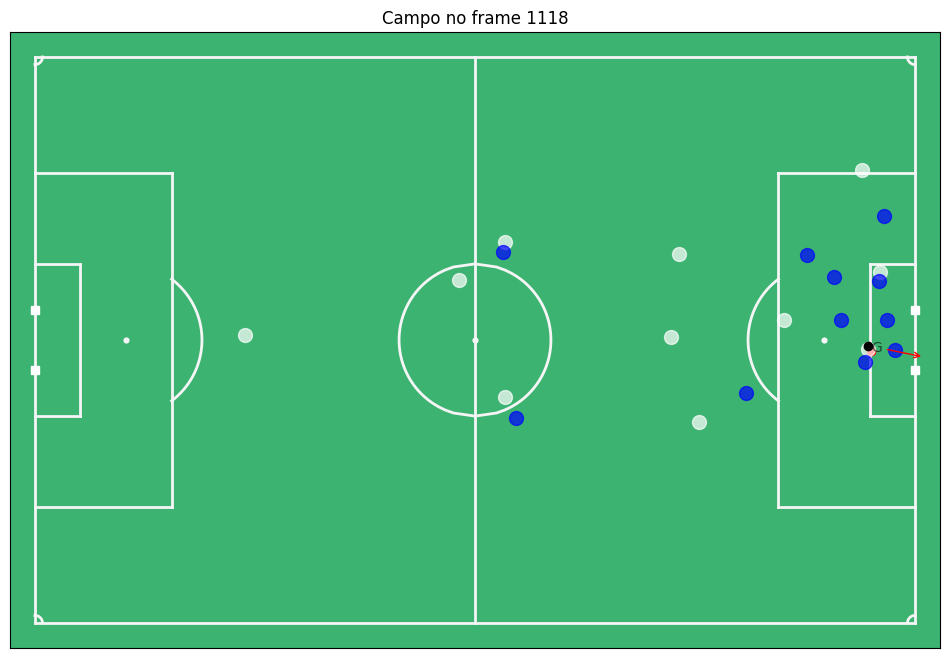

In [217]:
plotar_frame_adaptado(1118)

### Plot descrevendo a trajetória do jogador que finalizou considerando os 1500 frames anteriores ao gol/finalização

In [218]:
def plot_tragetoria_casa(index,player):
    fig,ax = mviz.plot_pitch()
    goal_frame = eventos_jogo_2.loc[index]['Start Frame']
    ax.plot( tracking_jogo_2_time_casa[f'Home_{player}_x'].iloc[goal_frame-1500:goal_frame+5], tracking_jogo_2_time_casa[f'Home_{player}_y'].iloc[goal_frame-1500:goal_frame+5], 'r.', markersize=1)
    plt.title(f'Tragetoria do jogador da casa {player} antes do frame {index}')

In [219]:
def plot_tragetoria_visitante(index,player):
    fig,ax = mviz.plot_pitch()
    goal_frame = eventos_jogo_2.loc[index]['Start Frame']
    ax.plot( tracking_jogo_2_time_visitante[f'Away_{player}_x'].iloc[goal_frame-1500:goal_frame+5], tracking_jogo_2_time_visitante[f'Away_{player}_y'].iloc[goal_frame-1500:goal_frame+5], 'r.', markersize=1)
    plt.title(f'Tragetoria do jogador visitante {player} antes do frame {index}')

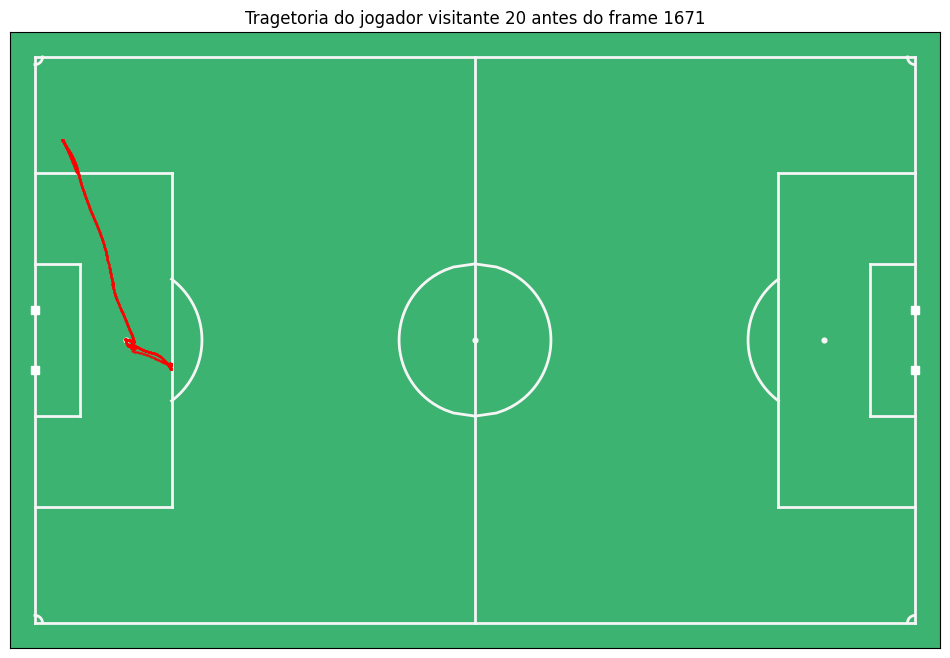

In [220]:
plot_tragetoria_visitante(1671,20)

A título de curiosidade sobre o  que aconteceu antes do penalti

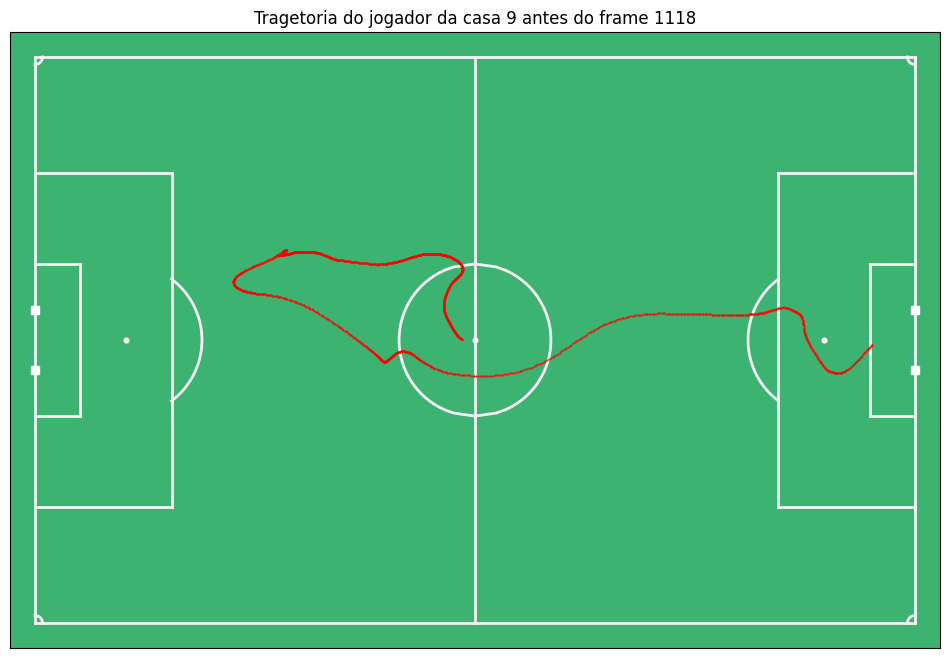

In [221]:
plot_tragetoria_casa(1118,9)

## Parte 2

- Utilize o código de "Tutorial2_DelvingDeeper.py" para calcular as velocidades dos jogadores em cada frame. Em seguida faça o plot de um frame qualquer incluindo vetores de velocidade.

- Crie um resumo físico para os jogadores envolvidos na partida. Plote as distâncias percorridas por cada jogador em cada ritmo (walking, jogging, running, sprinting)

    - Você consegue dizer a partir desse resumo quais jogadores são os goleiros?

- Por fim, escolha um jogador e faça um plot com seus sprints no campo


### Plot com velocidades

In [222]:
def to_single_playing_direction(home,away,events):
    for team in [home,away,events]:
        second_half_idx = team.Period.idxmax()
        columns = [c for c in team.columns if c[-1].lower() in ['x','y']]
        team.loc[second_half_idx:,columns] *= -1
    return home,away,events

In [223]:
tracking_jogo_2_time_casa,tracking_jogo_2_time_visitante,eventos_jogo_2 = to_single_playing_direction(tracking_jogo_2_time_casa,tracking_jogo_2_time_visitante,eventos_jogo_2)

tracking_jogo_2_time_casa = calc_player_velocities(tracking_jogo_2_time_casa,smoothing=True)
tracking_jogo_2_time_visitante = calc_player_velocities(tracking_jogo_2_time_visitante,smoothing=True)

In [224]:
def plotar_frame_com_velocidade(index):
    plot_frame( tracking_jogo_2_time_casa.loc[index], tracking_jogo_2_time_visitante.loc[index], include_player_velocities=True, annotate=True)
    plt.title('Campo no frame {index}')

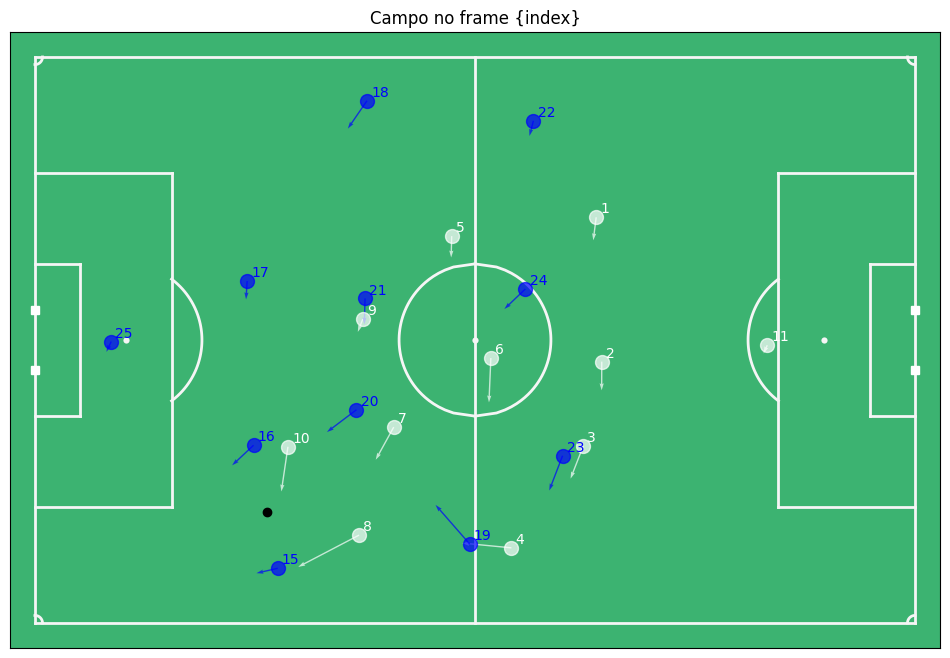

In [225]:
plotar_frame_com_velocidade(412)

### Distâncias percorridas por cada jogador em cada ritmo do time da casa

Text(0.5, 1.0, 'Distâncias percorridas por cada jogador em cada ritmo')

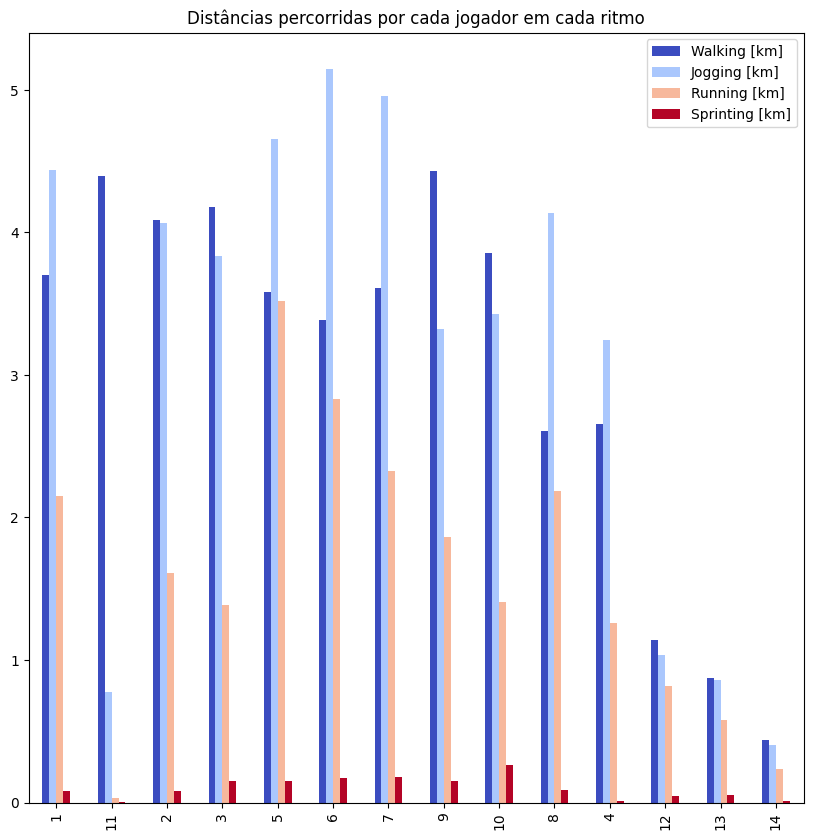

In [226]:
home_players = np.unique( [ c.split('_')[1] for c in tracking_jogo_2_time_casa.columns if c[:4] == 'Home' ] )
home_summary = pd.DataFrame(index=home_players)

minutes = []
for player in home_players:

    column = 'Home_' + player + '_x'
    player_minutes = ( tracking_jogo_2_time_casa[column].last_valid_index() - tracking_jogo_2_time_casa[column].first_valid_index() + 1 ) / 25 / 60.
    minutes.append( player_minutes )
home_summary['Minutes Played'] = minutes
home_summary = home_summary.sort_values(['Minutes Played'], ascending=False)

distance = []
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    player_distance = tracking_jogo_2_time_casa[column].sum()/25./1000
    distance.append( player_distance )
home_summary['Distance [km]'] = distance

walking,jogging,running,sprinting = [],[],[],[]
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    # walking (less than 2 m/s)
    player_distance = tracking_jogo_2_time_casa.loc[tracking_jogo_2_time_casa[column] < 2, column].sum()/25./1000
    walking.append( player_distance )
    # jogging (between 2 and 4 m/s)
    player_distance = tracking_jogo_2_time_casa.loc[ (tracking_jogo_2_time_casa[column] >= 2) & (tracking_jogo_2_time_casa[column] < 4), column].sum()/25./1000
    jogging.append( player_distance )
    # running (between 4 and 7 m/s)
    player_distance = tracking_jogo_2_time_casa.loc[ (tracking_jogo_2_time_casa[column] >= 4) & (tracking_jogo_2_time_casa[column] < 7), column].sum()/25./1000
    running.append( player_distance )
    # sprinting (greater than 7 m/s)
    player_distance = tracking_jogo_2_time_casa.loc[ tracking_jogo_2_time_casa[column] >= 7, column].sum()/25./1000
    sprinting.append( player_distance )

home_summary['Walking [km]'] = walking
home_summary['Jogging [km]'] = jogging
home_summary['Running [km]'] = running
home_summary['Sprinting [km]'] = sprinting
home_summary[['Walking [km]','Jogging [km]','Running [km]','Sprinting [km]']].plot.bar(colormap='coolwarm', figsize=(10,10))
plt.title('Distâncias percorridas por cada jogador em cada ritmo')

Acredito ser o 11 pois ele só andou o jogo inteiro.

### Plot de um jogador com seus sprints no campo

Text(0.5, 1.0, 'Sprints do jogador 9')

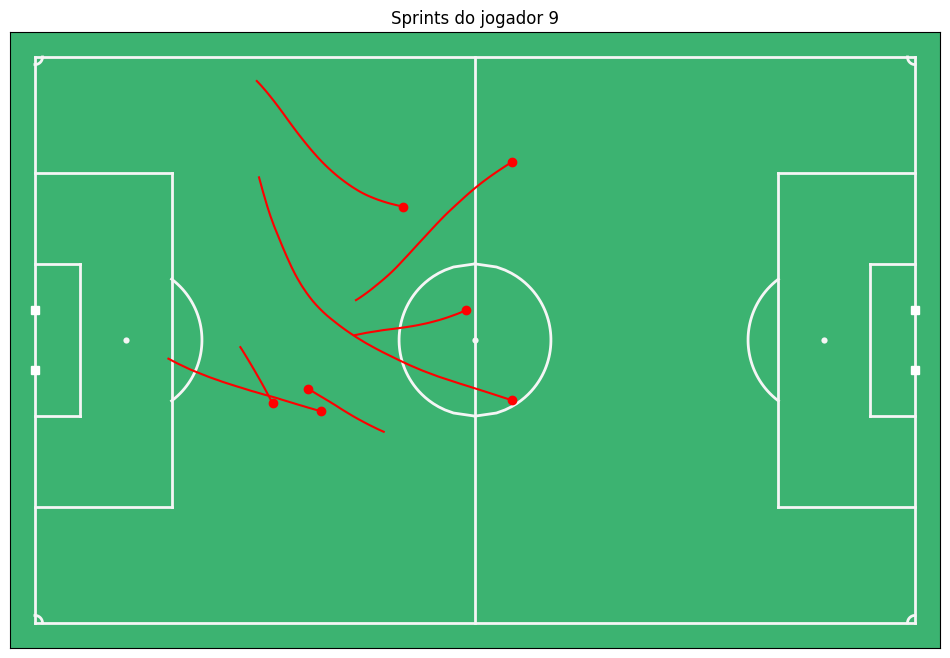

In [227]:
sprint_threshold = 7
sprint_window = 1*25

player = '9'
column = 'Home_' + player + '_speed' 
column_x = 'Home_' + player + '_x'
column_y = 'Home_' + player + '_y' 

player_sprints = np.diff( 1*( np.convolve( 1*(tracking_jogo_2_time_casa[column]>=sprint_threshold), np.ones(sprint_window), mode='same' ) >= sprint_window ) )
player_sprints_start = np.where( player_sprints == 1 )[0] - int(sprint_window/2) + 1
player_sprints_end = np.where( player_sprints == -1 )[0] + int(sprint_window/2) + 1
fig,ax = mviz.plot_pitch()
for s,e in zip(player_sprints_start,player_sprints_end):
    ax.plot(tracking_jogo_2_time_casa[column_x].iloc[s],tracking_jogo_2_time_casa[column_y].iloc[s],'ro')
    ax.plot(tracking_jogo_2_time_casa[column_x].iloc[s:e+1],tracking_jogo_2_time_casa[column_y].iloc[s:e+1],'r')

ax.set_title(f'Sprints do jogador {player}')